# Librerias

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 8.9 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle

# Colab-drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cargar caracteristicas

In [ ]:
ruta = '/content/drive/MyDrive/Teoría de grafos/urban/Datos/DatosAcousticIndices.pickle'

with open(ruta, 'rb') as data:
    unserialized_data = pickle.load(data)
    X_vgg = unserialized_data['X']
    y_vgg = unserialized_data['y']

In [ ]:
X_vgg[np.isinf(X_vgg)] = 0
X_vgg[np.isnan(X_vgg)] = 0

In [ ]:
X_tensor = torch.tensor(X_vgg, dtype=torch.float)
Y_tensor = torch.tensor(y_vgg, dtype=torch.uint8)
Y_tensor = Y_tensor.squeeze()

#GPU?

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creacion de grafos

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph, radius_graph
from torch_geometric.utils import index_to_mask

from random import sample, shuffle

In [ ]:
tensor = torch.tensor(range(0,len(y_vgg)))

In [ ]:
l_val = sample(tensor.tolist(), round(len(y_vgg) * 0.1))
val_mask = index_to_mask(torch.tensor(l_val), len(y_vgg))

In [ ]:
l_test = sample(tensor[~val_mask].tolist(), round(len(y_vgg) * 0.1))
test_mask = index_to_mask(torch.tensor(l_test), len(y_vgg))

In [ ]:
l_train = val_mask + test_mask
train_mask = ~l_train

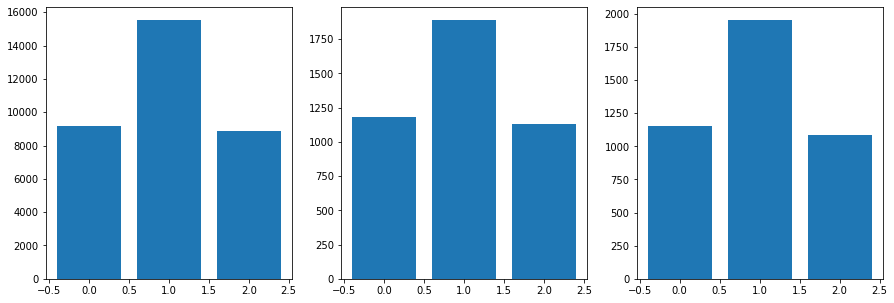

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(131), plt.bar([0,1,2], [np.sum(y_vgg[train_mask] == 0.0),np.sum(y_vgg[train_mask] == 1.0),np.sum(y_vgg[train_mask] == 2.0)])
plt.subplot(132), plt.bar([0,1,2], [np.sum(y_vgg[val_mask] == 0.0),np.sum(y_vgg[val_mask] == 1.0),np.sum(y_vgg[val_mask] == 2.0)])
plt.subplot(133), plt.bar([0,1,2], [np.sum(y_vgg[test_mask] == 0.0),np.sum(y_vgg[test_mask] == 1.0),np.sum(y_vgg[test_mask] == 2.0)])
plt.show()

In [ ]:
mini = X_tensor[train_mask].min()
maxi = X_tensor[train_mask].max()
X_tensor_norm = (X_tensor - mini) / (maxi - mini)

In [ ]:
from torch_geometric.transforms import RandomNodeSplit

In [ ]:
x = X_tensor_norm

#Labels nodes

y = Y_tensor


#Se crea las conexines de los nodos

edge_index = knn_graph(x, k = 4, batch=y,cosine = False , loop=False)


  #Creacion del grafo 

data = Data(x=x, edge_index= edge_index, y = y , train_mask = train_mask, test_mask = test_mask, val_mask = val_mask)# edge_index tensor que define los nodos de origen y desdetino.

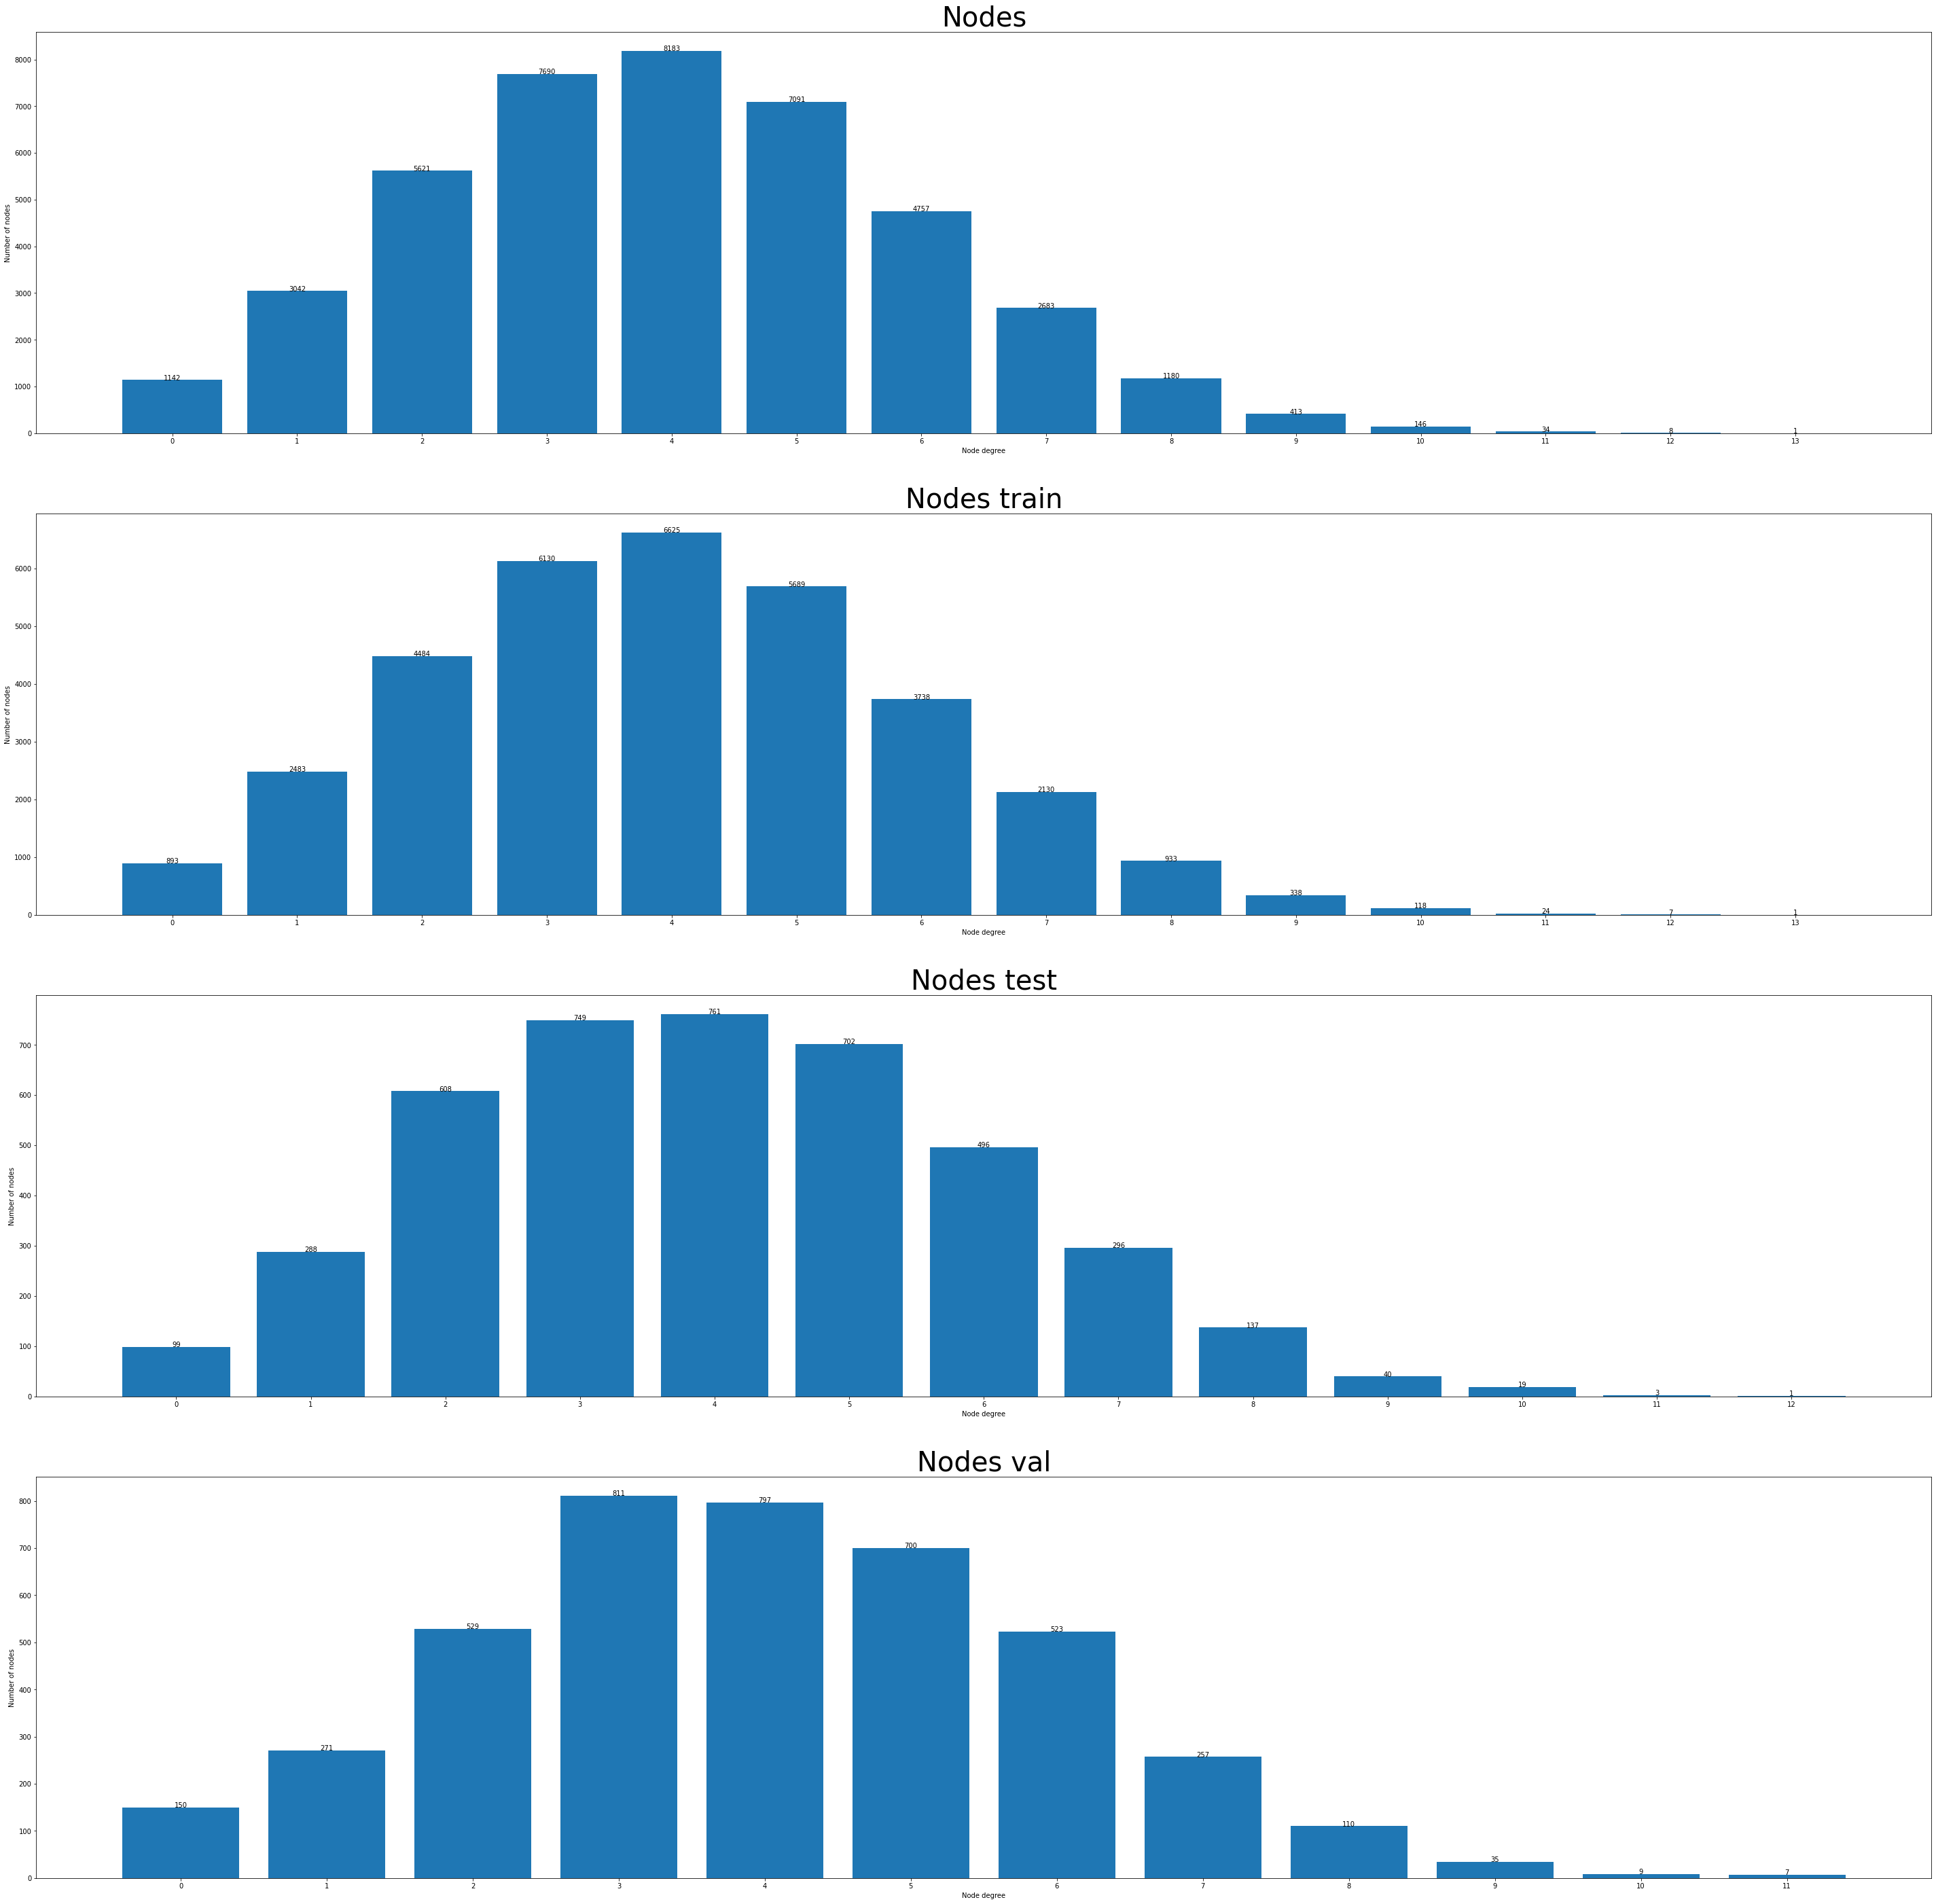

In [ ]:
from torch_geometric.utils import degree
from collections import Counter


plt.figure(figsize = (50,50))

degrees = degree(data.edge_index[0], 41991).numpy()
numbers = Counter(degrees)

list_numbers_keys = list(map(lambda i: int(i), list(numbers.keys())))
list_numbers_values = list(map(lambda i: int(i), list(numbers.values())))

plt.subplot(411)

plt.title('Nodes',fontsize=40)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.bar(list_numbers_keys,list_numbers_values, tick_label = list_numbers_keys)




for i in range(len(list_numbers_keys)):

  plt.text(list_numbers_keys[i],list_numbers_values[i],list_numbers_values[i], ha='center')



degrees_train = degrees[train_mask]
numbers_train = Counter(degrees_train)


list_numbers_train_keys = list(map(lambda i: int(i), list(numbers_train.keys())))
list_numbers_train_values = list(map(lambda i: int(i), list(numbers_train.values())))

plt.subplot(412)

plt.title('Nodes train',fontsize=40)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.bar(list_numbers_train_keys,list_numbers_train_values, tick_label = list_numbers_train_keys)




for i in range(len(list_numbers_train_keys)):

  plt.text(list_numbers_train_keys[i],list_numbers_train_values[i],list_numbers_train_values[i], ha='center')


#====================================================================================================
degrees_test = degrees[test_mask]
numbers_test = Counter(degrees_test)


list_numbers_test_keys = list(map(lambda i: int(i), list(numbers_test.keys())))
list_numbers_test_values = list(map(lambda i: int(i), list(numbers_test.values())))



plt.subplot(413)

plt.title('Nodes test',fontsize=40)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')


plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.bar(list_numbers_test_keys,list_numbers_test_values, tick_label = list_numbers_test_keys)




for i in range(len(list_numbers_test_keys)):

  plt.text(list_numbers_test_keys[i],list_numbers_test_values[i],list_numbers_test_values[i], ha='center')


#====================================================================================================

degrees_val = degrees[val_mask]
numbers_val = Counter(degrees_val)


list_numbers_val_keys = list(map(lambda i: int(i), list(numbers_val.keys())))
list_numbers_val_values = list(map(lambda i: int(i), list(numbers_val.values())))

plt.subplot(414),

plt.title('Nodes val',fontsize=40)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.bar(list_numbers_val_keys,list_numbers_val_values, tick_label = list_numbers_val_keys)




for i in range(len(list_numbers_val_keys)):

  plt.text(list_numbers_val_keys[i],list_numbers_val_values[i],list_numbers_val_values[i], ha='center')

plt.show()

In [ ]:
data.to(device)

Data(x=[41991, 60], edge_index=[2, 167964], y=[41991], train_mask=[41991], test_mask=[41991], val_mask=[41991])

# Train Test Val

In [ ]:
def accuracy(pred_y, y):
    
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data, mask):
    
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(torch.argmax(out, dim = 1)[mask], data.y[mask])
    return acc

def train(model, data, epoch):
    
    f_loss = nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = epoch

    model.train()
    for epoch in range(epochs+1):
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = f_loss(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(torch.argmax(out, dim = 1)[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        
        
        val_acc = test(model, data, data.val_mask)

        
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% |' f'Val Acc: {val_acc*100:.2f}%')
          
    return model

# Modelos

In [ ]:
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

## GAT

In [ ]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=10):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
  
    return h

In [ ]:
gat = GAT(60, 30, 3).to(device)

In [ ]:
train(gat, data, epoch = 100)
ac = test(gat, data, data.test_mask)
print(f'======================================================== \nAccuracy: {ac* 100:.2f}%')

Epoch   0 | Train Loss: 1.101 | Train Acc:  31.14% |Val Acc: 45.01%
Epoch  10 | Train Loss: 1.062 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  20 | Train Loss: 1.064 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  30 | Train Loss: 1.061 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  40 | Train Loss: 1.060 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  50 | Train Loss: 1.060 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  60 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  70 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  80 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  90 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch 100 | Train Loss: 1.057 | Train Acc:  46.26% |Val Acc: 45.03%
Accuracy: 46.56%


## GCN

In [ ]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    
    return h

In [ ]:
gcn = GCN(60, 40, 3).to(device)

In [ ]:
train(gcn, data, epoch = 100)
ac = test(gcn, data, data.test_mask)
print(f'======================================================== \nAccuracy: {ac* 100:.2f}%')

Epoch   0 | Train Loss: 1.089 | Train Acc:  42.23% |Val Acc: 44.68%
Epoch  10 | Train Loss: 1.076 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  20 | Train Loss: 1.068 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  30 | Train Loss: 1.064 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  40 | Train Loss: 1.062 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  50 | Train Loss: 1.062 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  60 | Train Loss: 1.061 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  70 | Train Loss: 1.061 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  80 | Train Loss: 1.060 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  90 | Train Loss: 1.060 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch 100 | Train Loss: 1.060 | Train Acc:  46.26% |Val Acc: 45.03%
Accuracy: 46.56%


## SAGE

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5)
        h = self.conv2(h, edge_index)
       
        return h

In [ ]:
g_sage = GraphSAGE(60, 30, 3).to(device)

In [ ]:
train(g_sage, data, epoch = 100)
ac = test(g_sage, data, data.test_mask)
print(f'======================================================== \n Accuracy: {ac* 100:.2f}%')

Epoch   0 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  10 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  20 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  30 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.01%
Epoch  40 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  50 | Train Loss: 1.059 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  60 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  70 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  80 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch  90 | Train Loss: 1.058 | Train Acc:  46.26% |Val Acc: 45.03%
Epoch 100 | Train Loss: 1.055 | Train Acc:  46.26% |Val Acc: 45.03%
 Accuracy: 46.56%
